## 第一部分

### 简答题

1. 为什么激活函数是训练一个多层感知机（MLP）的关键要素

激活函数将最终的结果映射到指定的范围内。
如果不写激活函数，那么无论叠加多少层感知机，最终得到的结果也是线性的。

2. 列举三种常用的激活函数，说明一下它们的大概形状

sigmoid函数：S形状，映射到（0，1）范围内

relu函数：max(0,x)，对所有负的输入输出为0，正的输入输出为本身

tanh函数：S形状，映射到（-1，1）范围内，以0为中心

3. 反向传播的算法解决什么问题，如何工作的

解决：计算损失函数相对于所有权重和偏置参数的梯度

工作流程：前向传播——计算误差——通过误差反向传播迭代计算梯度

4. 列出可以在基本MLP（不考虑其他神经网络架构）中进行调整的所有超参数？如果MLP过拟合训练数据，如何调整这些超参数来解决该问题？

隐藏层数量，每一层的神经元数量、学习率、正则化强度、批次大小、激活函数

过拟合的情况下可以选择减少神经元数量、减少隐藏层数量；加强正则化；使用早停


5. 假设有一个MLP，该MLP由一个输入层，10个特征，随后是一个包含50个神经元的隐藏层，最后是3个神经元组成的输出层。所有人工神经元都使用ReLU激活函数。

   a. 输入矩阵X的形状是什么

X是一个批次的输入数据，那么X的形状为[批次大小,10]

   b. 隐藏层的权重W_hidden及其偏置b_hidden的形状分别是什么

隐藏层的权重W_hidden的形状为：[10,50],因为输入下一层的形状需要是[批次大小,50]
偏置b_hidden的形状：[1,50]

   c. 输出层的权重W_output及其偏置b_output的形状是什么

输出层的权重W_output的形状为：[50,3]
偏置b_output：[1,3]

   d. 网络输出矩阵Y的形状是什么

网格输出矩阵Y的形状为[批次大小,3]

   e. 写出输出矩阵Y的计算公式，满足Y是W_hidden, b_hidden, W_output, b_output的函数

Y = relu(relu(X@W_hidden+b_hidden)@W_output+b_output)

6. 如果要将电子邮件分类为垃圾邮件或正常邮件，需要在输出层中有多少个神经元？应该在输出层中使用什么激活函数？相反，如果想解决MNIST图片分类问题，则在输出层中需要有多少个神经元，应该使用哪种激活函数？如何使神经网络预测 回归话题里提到的房价？

将电子邮件分类为垃圾邮件或正常邮件，需要在输出层中有1个神经元，使用sigmoid函数

MNIST图片分类问题，则在输出层中需要有10个神经元，使用softmax函数

神经网络解决回归的房价问题：使用一个神经元，不用激活函数，得到线性的结果

### 编程题

在MNIST数据集上训练深度MLP（可以使用tf.keras.datasets.mnist.load_data()加载它）。看看是否可以通过手动调整超参数获得98%以上的精度。

首先尝试使用课堂上介绍的方法搜索最佳学习率（即通过以指数方式增加学习率，根据学习率变化绘制训练损失，并找到损失激增的点）。

接下来，尝试使用Keras Tuner调整超参数——保存检查点，使用早停，并使用TensorBoard绘制学习曲线。

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt

(X1,y1),(X2,y2) = tf.keras.datasets.mnist.load_data()

In [2]:
X1 = X1.astype('float32') / 255.0
X2 = X2.astype('float32') / 255.0

In [44]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self,step):
        super().__init__()
        self.step = step

    def on_train_begin(self, logs):
        self.loss_list = []
        self.learning_rates = []
    def on_epoch_end(self, epoch, logs):
        if logs is not None:
            # 正确获取当前学习率
            current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))

            # 记录损失和学习率
            self.loss_list.append(logs.get('loss'))
            self.learning_rates.append(current_lr)

            new_lr = current_lr * self.step
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)

    def on_train_end(self, logs):  # 添加logs参数，即使不使用
        if not self.learning_rates or not self.loss_list:
            print("没有数据可绘制")

        plt.figure(figsize=(10, 6))
        plt.gca().set_xscale("log")
        plt.plot(self.learning_rates, self.loss_list, "r-")
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate vs Loss')
        plt.grid(True, which="both", ls="--")
        plt.show()


In [48]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
for _ in range(7):
    model.add(tf.keras.layers.Dense(25,activation="relu"))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.add(tf.keras.layers.Dense(10,activation="softmax"))
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])

Epoch 1/50
1875/1875 [==============================] - 8s 3ms/step - loss: 0.4604 - accuracy: 0.8569
Epoch 2/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2071 - accuracy: 0.9404
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1652 - accuracy: 0.9512
Epoch 4/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1437 - accuracy: 0.9573
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1311 - accuracy: 0.9613
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1224 - accuracy: 0.9632
Epoch 7/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1140 - accuracy: 0.9667
Epoch 8/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1099 - accuracy: 0.9681
Epoch 9/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1054 - accuracy: 0.9690
Epoch 10/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.101

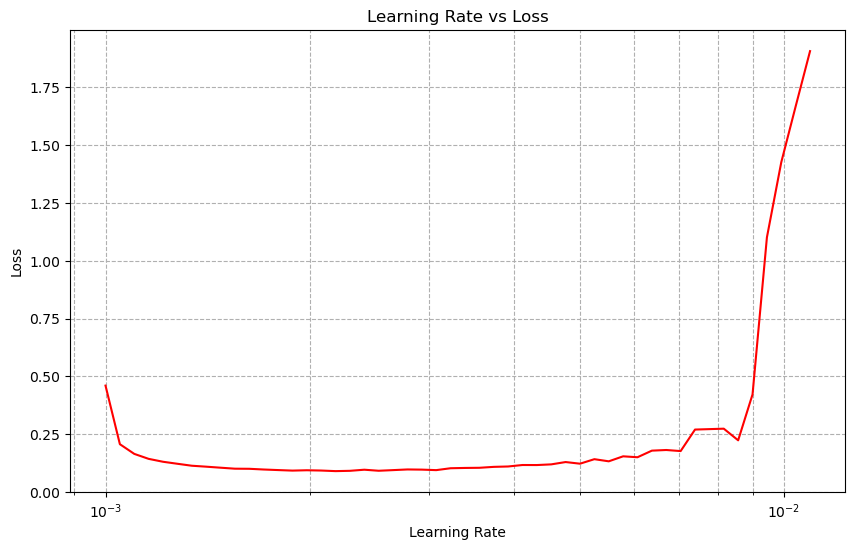

In [49]:
tf.keras.backend.clear_session()
my_callback = MyCallback(1.05)
model.fit(X1,y1,epochs=50,callbacks=[my_callback])

In [72]:
import numpy as np
best_learning_rate = my_callback.learning_rates[np.argmin(my_callback.loss_list)]

In [73]:
import keras_tuner as kt
class MyClassHyperModel(kt.HyperModel):
    def build(self, hp):
        n_layers = hp.Int("n_layers", 2,10,default=2)
        n_neurons = hp.Int("n_neurons", 16,256)


        optimizer = tf.keras.optimizers.SGD(learning_rate=best_learning_rate)

        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Flatten())
        for _ in range(n_layers):
            model.add(tf.keras.layers.Dense(n_neurons,activation="relu"))

        model.add(tf.keras.layers.Dense(10,activation="softmax"))
        model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
        return model
    def fit(self,hp,model,X,y,**kwargs):
        # 获取传入的回调函数（如果有的话）
        callbacks = kwargs.pop('callbacks', [])
        my_callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
        callbacks.append(my_callbacks)

        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            norm_layer.adapt(X)
            X = norm_layer(X)
        batch_size = hp.Int("batch_size", 2,128, default=32)
        return model.fit(X,y,callbacks=callbacks,batch_size=batch_size,**kwargs)


In [75]:
my_hy = MyClassHyperModel()
random_search_tuner = kt.RandomSearch(my_hy,objective="val_accuracy",max_trials=10,overwrite=True,project_name="my_hy",seed=42,directory="./models/my_mnist")
random_search_tuner.search(X1,y1,validation_data=(X2,y2))

Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.7932999730110168

Best val_accuracy So Far: 0.8812999725341797
Total elapsed time: 00h 02m 26s


In [79]:
top3_model = random_search_tuner.get_best_models(num_models=3)
best_model = top3_model[0]
# 获取最佳模型的超参数

top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

{'n_layers': 6, 'n_neurons': 115, 'normalize': False, 'batch_size': 11}

In [80]:
from pathlib import Path
from time import strftime
def get_run_logdir(root_logdir="logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=get_run_logdir(),profile_batch=(0,5))
best_model.fit(X1,y1,validation_data=(X2,y2),epochs=20,callbacks=[tensorboard_cb])

Epoch 1/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3531 - accuracy: 0.8967 - val_loss: 0.3156 - val_accuracy: 0.9071
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3056 - accuracy: 0.9110 - val_loss: 0.2867 - val_accuracy: 0.9158
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2719 - accuracy: 0.9213 - val_loss: 0.2493 - val_accuracy: 0.9282
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2452 - accuracy: 0.9291 - val_loss: 0.2295 - val_accuracy: 0.9324
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2221 - accuracy: 0.9351 - val_loss: 0.2097 - val_accuracy: 0.9393
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2036 - accuracy: 0.9414 - val_loss: 0.1975 - val_accuracy: 0.9420
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1874 - accuracy: 0.9454 - val_loss: 0.1885 - val_accuracy

In [33]:
%load_ext tensorboard
%tensorboard --logdir=./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1124), started 1:02:14 ago. (Use '!kill 1124' to kill it.)

## 第二部分

第二部分要求构建一个基本的softmax回归算法，以及一个简单的两层神经网络。将使用原生Python（使用numpy库），不借助keras实现这些算法

在此过程中，将提供一些关于如何实现这些不同函数的指导，但总体而言，细节需要自己实现。 应该尽量使用 numpy 中的线性代数调用：for/while循环通常会使代码运行速度比预期慢得多。

**请仔细阅读作业说明!!!**

去命令行（cmd/Anaconda Powershell Prompt /其他终端）运行如下指令（激活开发环境一定要最先执行），安装这部分作业依赖的python库：
- 激活开发环境：conda activate homl3
- 安装numdifftools：conda install numdifftools
- 安装pytest：conda install pytest


### 第一题：简单的加法函数，以及使用pytest测试代码

为了说明这部分作业的代码+数据，以及pytest使用，将使用一个实现 add函数 的简单示例。

```
data/
    train-images-idx3-ubyte.gz
    train-labels-idx1-ubyte.gz
    t10k-images-idx3-ubyte.gz
    t10k-labels-idx1-ubyte.gz
src/
    simple_ml.py
tests/
    test_simple_ml.py
```

data/ 目录包含这部分作业所需的数据（MNIST 数据集的副本）；src/ 目录包含实现功能所需的源代码；tests/ 目录包含用于测试实现代码是否正确的代码

第一题要求实现 src/目录里 simple_ml.py内的 add函数（这个简单的函数实际上并没有用到，它只是一个帮助熟悉作业结构的示例）。查看 src/simple_ml.py 文件，将找到 add() 函数的定义

```python
def add(x, y):
    """一个简单的add函数，以便熟悉自动测试（pytest）

    Args:
        x (Python数字 或者 numpy array)
        y (Python数字 或者 numpy array)

    Return:
        x+y的和
    """
    ### 你的代码开始
    pass
    ### 你的代码结束
```

函数内的文档字符串（docstring）定义了函数应该产生的预期输入和输出（需要养成仔细阅读文档的习惯，很多错误来源就是没有阅读规范）。实现这个函数。你只需将 pass 语句替换为正确的代码即可，即：

```python
def add(x, y):
    """一个简单的add函数，以便熟悉自动测试（pytest）

    Args:
        x (Python数字 或者 numpy array)
        y (Python数字 或者 numpy array)

    Return:
        x+y的和
    """
    ### 你的代码开始
    return x + y
    ### 你的代码结束
```

现在可以去src/simple_nn.py里，把add函数里的pass 换成 return x + y

#### 测试代码

现在需要测试一下你的代码是否能正确运行，正确运行才说明实现没问题。

在这部分作业中，将使用pytest对代码进行单元测试。在 src/simple_ml.py 文件中 写完 add函数的实现后，去命令行里确保已经激活了homl3环境（conda activate homl3）， 确保homl3环境里安装过了numdifftools和pytest，确定命令行里显示的文件路径在 作业8的目录（这个目录同时有data/, src/和tests/文件夹），然后执行以下命令：

python -m pytest -k "add"

如果一切正常，你会看到类似这样的图片：
![测试add通过](../../images/homework/neural_network/p1.png)

想看测试如何进行的，可以去查看tests/test_simple_ml.py文件，python -m pytest -k "add"指令刚刚运行的是 文件里的test_add() 函数

如果错误地实现了某些内容（例如，将上面的 x + y 更改为 x - y），那么测试将会失败，并且 pytest 将会指示相应的测试失败。

比如把x+y，换成x-y后，执行python -m pytest -k "add"：
![测试add不通过](../../images/homework/neural_network/p2.png)

b如图所见，将收到一个错误，指示断言失败，然后就可以使用它来返回并调整实现代码。应该能够熟练地阅读和跟踪测试文件，以便更好地理解正确的实现应该如何工作

学习正确开发和使用单元测试对于现代软件开发至关重要，希望这次作业帮助了解单元测试在软件开发中的典型用法。

当然，这次作业不一定需要编写自己的测试去确保自己实现正确，但应该熟悉如何阅读提供的测试文件，以便了解要实现的函数应该如何运行。但是，也绝对鼓励为自己的实现编写额外的测试。

如果习惯通过打印语句调试代码，请注意，pytest 默认会捕获任何输出（隐藏掉测试代码执行的print）。可以通过将 -s 传递给 pytest 来禁用此行为并让测试在所有情况下显示所有输出。

### 第二题：用gzip和struct处理压缩文件和二进制数据，加载MNIST数据

现在已经熟悉了测试工具pytest，接下来在 src/simple_ml.py 中需要实现的函数上尝试一下：parse_mnist_data() 函数。

这个函数也有文档字符串（docstring），请仔细阅读它们。

然后，请访问  https://web.archive.org/web/20220509025752/http://yann.lecun.com/exdb/mnist/ 了解 MNIST 数据的二进制格式。然后编写函数读取此类文件，并根据文档字符串中的规范返回 numpy 数组）。建议使用 Python 中的 struct 模块（以及 gzip 模块，当然还有 numpy 本身）来实现此函数。

当然可以利用AI搜索这个部分的代码实现，但了解了MNIST数据的二进制格式和gzip，struct的简单使用后，能理解AI产出的代码为什么正确

实现函数后，去命令行运行本地单元测试， 同样确保命令行激活了homl3环境，确保路径在作业8目录下（有data/,src/和tests/文件）， 后面的题不再强调

python -m pytest -k "parse_mnist"

### 第三题：Softmax损失

在 `src/simple_ml.py` 文件的 `softmax_loss()` 函数中实现 softmax（也称为交叉熵）损失。对于一个可以取值 $ y \in \{1, \ldots, k\} $ 的多类输出，softmax 损失接收一个对数几率向量 $ z \in \mathbb{R}^k $ 和真实类别 $ y \in \{1, \ldots, k\} $ 作为输入，并返回由以下公式定义的损失：

$\ell_{\text{softmax}}(z, y) = \log (\sum_{i=1}^{k} \exp z_i) - z_y$

对数几率向量z，可以看成被softmax激活之前的值，对公式有疑惑，或者对z的意义有疑惑的，可以参考softmax回归的笔记，并自己推导一下损失公式是否正确

请注意，如其文档字符串（docstring）所述，`softmax_loss()` 函数接收一个二维的对数几率数组（即，一批不同样本的 $ k $ 维对数几率）加上一个对应的一维真实标签数组，并应返回整批样本的平均 softmax 损失。请注意，为了正确实现此功能，你不应使用任何循环，而是完全使用 numpy 的向量化操作进行计算（为此设定预期，实现代码可以少到一行代码）。

实现完成后，可以去命令行进行单元测试：python -m pytest -k "softmax_loss"

### 第四题：softmax回归小批量梯度下降

在这个问题中，你将实现（线性）softmax 回归的小批量梯度下降）。考虑一个假设函数，该函数通过以下公式将 $ n $ 维输入转换为 $ k $ 维对数几率：

$h(x) = \Theta^T x$

其中 $ x \in \mathbb{R}^n $ 是输入，$\Theta \in \mathbb{R}^{n \times k}$ 是模型参数。给定数据集 $\{(x^{(i)} \in \mathbb{R}^n, y^{(i)} \in \{1, \ldots, k\})\}$，其中 $ i = 1, \ldots, m $，softmax 回归相关的优化问题因此由下式给出：

$\text{minimize} \frac{1}{m} \sum_{i=1}^{m} \ell_{\text{softmax}} (\Theta^T x^{(i)}, y^{(i)})$

线性 softmax 目标的梯度由下式给出，有疑惑的可以结合softmax回归的笔记验证

$\nabla_\Theta \ell_{\text{softmax}} (\Theta^T x, y) = x(z - e_y)^T$

其中

$z = \frac{\exp(\Theta^T x)}{1^T \exp(\Theta^T x)} = \text{normalize}(\exp(\Theta^T x))$

（即 $ z $ 只是归一化的 softmax 概率），并且 $ e_y $ 表示 y 分类的独热编码，即一个所有元素为零，只有第 $ y $ 个位置为 1 的向量。

也可以用更紧凑的符号来表示，方便代码实现，即，如果让 $ X \in \mathbb{R}^{m \times n} $ 表示某个 $ m $ 个输入的特征矩阵（整个数据集或一个小批量），$ y \in \{1, \ldots, k\}^m $ 是对应的标签向量，并且 $ \ell_{\text{softmax}} $ 表示平均 softmax 损失，那么

$\nabla_\Theta \ell_{\text{softmax}}(X \Theta, y) = \frac{1}{m} X^T (Z - I_y)$

其中

$Z = \text{normalize}(\exp(X \Theta)) \quad (\text{归一化按行应用})$

表示对数几率矩阵，而 $ I_y \in \mathbb{R}^{m \times k} $ 表示 $ y $ 中标签的 逐个转成 独热编码，按行连接

使用这些梯度，实现 `softmax_regression_epoch()` 函数，该函数使用指定的学习率/步长 $ \eta $ 和小批量大小 `batch_size` 运行单个轮次（对数据集的一次遍历）。如其文档字符串所述，你的函数应该就地修改 Theta 数组。实现后，请去命令行运行测试。

python -m pytest -k "softmax_regression_epoch"

#### 用softmax回归训练MNIST

虽然这不包含在测试中，但既然你已经编写了这段代码，你也可以尝试使用 SGD 训练一个完整的 MNIST 线性分类器。为此，你可以使用 src/simple_ml.py 文件中的 train_softmax() 函数（已经编写好了这个函数，所以无需自行编写，但可以查看一下它的功能）。

可以使用以下代码了解它的工作原理。作为参考，如下所示，我的实现在 notebook 上运行时间约为 2 秒，测试集错误率为 7.97%。

In [1]:
import sys
sys.path.append("src/")
from src.simple_nn import train_softmax, parse_mnist

X_tr, y_tr = parse_mnist("data/train-images-idx3-ubyte.gz",
                         "data/train-labels-idx1-ubyte.gz")
X_te, y_te = parse_mnist("data/t10k-images-idx3-ubyte.gz",
                         "data/t10k-labels-idx1-ubyte.gz")

train_softmax(X_tr, y_tr, X_te, y_te, epochs=10, lr=0.2, batch=100)

| Epoch | Train Loss | Train Err | Test Loss | Test Err |
|     0 |    0.35134 |   0.10182 |   0.33588 |  0.09400 |
|     1 |    0.32142 |   0.09268 |   0.31086 |  0.08730 |
|     2 |    0.30802 |   0.08795 |   0.30097 |  0.08550 |
|     3 |    0.29987 |   0.08532 |   0.29558 |  0.08370 |
|     4 |    0.29415 |   0.08323 |   0.29215 |  0.08230 |
|     5 |    0.28981 |   0.08182 |   0.28973 |  0.08090 |
|     6 |    0.28633 |   0.08085 |   0.28793 |  0.08080 |
|     7 |    0.28345 |   0.07997 |   0.28651 |  0.08040 |
|     8 |    0.28100 |   0.07923 |   0.28537 |  0.08010 |
|     9 |    0.27887 |   0.07847 |   0.28442 |  0.07970 |


### 在1个隐藏层的神经网络上进行小批量梯度下降

现在已经为线性分类器编写了SGD，现在考虑一个简单的两层神经网络的情况。具体来说，对于输入 $ x \in \mathbb{R}^n $，考虑一个形式如下的两层神经网络（无偏置项）：

$ z = W_2^T ReLU(W_1^T x) $

其中 $ W_1 \in \mathbb{R}^{n \times d} $ 和 $ W_2 \in \mathbb{R}^{d \times k} $ 表示网络的权重（具有 $ d $ 维隐藏单元），而 $ z \in \mathbb{R}^k $ 表示网络输出的对数几率。我们再次使用 softmax/交叉熵损失，这意味着我们要解决以下优化问题：

$\text{minimize } \frac{1}{W_1, W_2} \sum_{i=1}^m \ell_{\text{softmax}}(W_2^T ReLU(W_1^T x^{(i)}), y^{(i)})$

或者，使用矩阵 $ X \in \mathbb{R}^{m \times n} $ 来描述批量形式，这也可以写成：

$\text{minimize } \ell_{\text{softmax}}(ReLU(XW_1)W_2, y)$

使用链式法则，可以推导出该网络的反向传播更新（为了便于实现，这里提供最终形式）。具体来说，令：

$Z_1 \in \mathbb{R}^{m \times d} = ReLU(XW_1)$

$G_2 \in \mathbb{R}^{m \times k} = \text{normalize}(\exp(Z_1 W_2)) - I_y$

$G_1 \in \mathbb{R}^{m \times d} = 1\{Z_1 > 0\} \circ (G_2 W_2^T)$

其中 $ 1\{Z_1 > 0\} $ 是一个二进制矩阵，其条目根据 $ Z_1 $ 中的每个项是否严格为正而等于零或一，而 $\circ$ 表示逐元素乘法。那么目标的梯度由下式给出：

$\nabla_{W_1} \ell_{\text{softmax}}(ReLU(XW_1)W_2, y) = \frac{1}{m} X^T G_1$

$\nabla_{W_2} \ell_{\text{softmax}}(ReLU(XW_1)W_2, y) = \frac{1}{m} Z_1^T G_2$

**注意：** 如果这些精确方程的细节对你来说有点神秘，不必太担心。这些只是两层ReLU网络的标准反向传播方程：$ Z_1 $ 项只是计算"前向"传播，而 $ G_2 $ 和 $ G_1 $ 项表示反向传播。但是更新的精确形式可能会因你使用的神经网络符号、制定损失函数的具体方式、是否之前以矩阵形式推导过这些等因素而有所不同。（毕竟，在某种程度上，深度学习系统（比如tensorflow）的整个重点是我们不需要费心进行这些手动计算）。


使用这些梯度，现在在 src/simple_ml.py 文件中编写 nn_epoch() 函数。与上一个问题一样，你的解决方案应该修改 W1 和 W2 数组。实现该函数后，运行以下测试。请务必使用上述表达式所示的矩阵运算来实现该函数：这比尝试使用循环更快、更高效（并且所需的代码也更少）。

实现完成后，去命令运行单元测试：python -m pytest -k "nn_epoch"

#### 训练神经网络

In [2]:
import sys


import importlib
import src.simple_nn as simple_nn
importlib.reload(simple_nn) # 重新载入simple_nn， 防止刚才的训练代码产生了缓存，影响了simple_nn

sys.path.append("src/")
from src.simple_nn import train_nn, parse_mnist

X_tr, y_tr = parse_mnist("data/train-images-idx3-ubyte.gz",
                         "data/train-labels-idx1-ubyte.gz")
X_te, y_te = parse_mnist("data/t10k-images-idx3-ubyte.gz",
                         "data/t10k-labels-idx1-ubyte.gz")
train_nn(X_tr, y_tr, X_te, y_te, hidden_dim=400, epochs=20, lr=0.2)

| Epoch | Train Loss | Train Err | Test Loss | Test Err |
|     0 |    0.15324 |   0.04697 |   0.16305 |  0.04920 |
|     1 |    0.09940 |   0.02985 |   0.11694 |  0.03710 |
|     2 |    0.07419 |   0.02143 |   0.09750 |  0.03220 |
|     3 |    0.05944 |   0.01717 |   0.08751 |  0.02890 |
|     4 |    0.04811 |   0.01338 |   0.08089 |  0.02530 |
|     5 |    0.03994 |   0.01068 |   0.07613 |  0.02420 |
|     6 |    0.03443 |   0.00882 |   0.07341 |  0.02270 |
|     7 |    0.03019 |   0.00760 |   0.07211 |  0.02250 |
|     8 |    0.02670 |   0.00628 |   0.07068 |  0.02180 |
|     9 |    0.02364 |   0.00553 |   0.06953 |  0.02110 |
|    10 |    0.02117 |   0.00488 |   0.06863 |  0.02110 |
|    11 |    0.01893 |   0.00393 |   0.06801 |  0.02040 |
|    12 |    0.01727 |   0.00338 |   0.06736 |  0.02070 |
|    13 |    0.01567 |   0.00285 |   0.06682 |  0.02060 |
|    14 |    0.01422 |   0.00248 |   0.06648 |  0.02070 |
|    15 |    0.01308 |   0.00222 |   0.06614 |  0.02070 |
|    16 |    0

作为参考，我的实现花了30多秒训练，最终在mnist的测试集达到了1.93%的错误率，只用了大概20多行代码